In [1]:
from model import Network
from data import load_cifar10_dataloaders, WhiteningTransformation
import torch
import torchvision.transforms as transforms
import torch.nn as nn
from criterion import ReconstructImageFromFCLoss
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from metrics import lpips_gpu, psnr

In [2]:
# load to model
model_config = './model_config/fc2_cocktail_party_cifar10_instance.json'
checkpoint_path = './checkpoints/122123_fc2_cocktail_party_cifar10_pretraining_wout_bias_wout_normalization.pth'
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = Network(model_config)
checkpoint = torch.load(checkpoint_path)
model.load_state_dict(checkpoint['state_dict'])
model = model.to(device)

# reproducibility
random_seed = 2024

torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

np.random.seed(random_seed)

# get val loader
batch_size = 16
data_path = './data'
transform = transforms.Compose([
    transforms.ToTensor(),
])

_, val_dataloader = load_cifar10_dataloaders(data_path, batch_size, transform)
selected_val_batch_data, selected_val_batch_label = next(iter(val_dataloader))
selected_val_batch_data = selected_val_batch_data.to(device)
selected_val_batch_label = selected_val_batch_label.to(device)

Files already downloaded and verified
Files already downloaded and verified


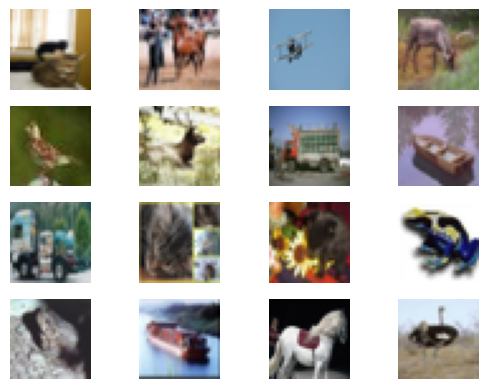

In [3]:
with torch.no_grad():
    fig, axes = plt.subplots(4, 4)
    
    for estimate, ax in zip(selected_val_batch_data, axes.flatten()):
        img = transforms.ToPILImage()(estimate.reshape(3, 32, 32))
        img = np.asarray(img)
        ax.imshow(img)
        ax.axis('off')
    plt.show()

In [4]:
# receiving gradients
model.zero_grad()
criterion = nn.CrossEntropyLoss()
output = model(selected_val_batch_data.reshape(batch_size, -1))
loss = criterion(output, selected_val_batch_label)
loss.backward()
gradient_of_layers = []
for param in model.parameters():
    gradient_of_layers.append(param.grad.data.clone().to('cpu'))
print([x.size() for x in gradient_of_layers])

[torch.Size([256, 3072]), torch.Size([10, 256])]


In [5]:
whitening_transform = WhiteningTransformation()
whitened_gradient = torch.from_numpy(whitening_transform.transform(gradient_of_layers[0].detach().numpy().T)).to(torch.float32).T
whitened_gradient = whitened_gradient.to(device)

In [6]:
# criterion output testing
unmixing_matrix = torch.rand((selected_val_batch_data.size(0), gradient_of_layers[0].size(0)), requires_grad=True, device=device)
reconstruction_loss = ReconstructImageFromFCLoss(32, 32, 3, 7.292239691495796, 0.8808567737062569, 8.98613115383271)
optimizer = torch.optim.Adam([unmixing_matrix])

for iter_idx in range(25000):
    optimizer.zero_grad()
    # out_score, non_gaussianity_score, total_variance_score, mutual_independence_score
    loss, _, _, _ = reconstruction_loss(unmixing_matrix, whitened_gradient)
    loss.backward()
    optimizer.step()
    
    if (iter_idx + 1) % 1000 == 0 or iter_idx == 0:
        print('loss: {}'.format(loss.item()))

loss: 2088.266845703125
loss: 44.03285217285156
loss: 15.04904842376709
loss: 9.402329444885254
loss: 9.131343841552734
loss: 9.122591972351074
loss: 9.113967895507812
loss: 9.107361793518066
loss: 9.10266399383545
loss: 9.098859786987305
loss: 9.093835830688477
loss: 9.088773727416992
loss: 9.084260940551758
loss: 9.07900333404541
loss: 9.073843002319336
loss: 9.069079399108887
loss: 9.063180923461914
loss: 9.057283401489258
loss: 9.052276611328125
loss: 9.045865058898926
loss: 9.041173934936523
loss: 9.03603458404541
loss: 9.030674934387207
loss: 9.025629997253418
loss: 9.020784378051758
loss: 9.015800476074219


In [7]:
unmixing_matrix = unmixing_matrix.detach().to('cpu')
whitened_gradient = whitened_gradient.detach().to('cpu')

## PSNR Values

In [8]:
with torch.no_grad():
    psnr_match, psnr_is_positive, mean_psnr = psnr(unmixing_matrix @ whitened_gradient, selected_val_batch_data.detach().to('cpu'), return_matches=True)

In [9]:
psnr_match

[tensor([7, 6]),
 tensor([6, 3]),
 tensor([2, 1]),
 tensor([15,  7]),
 tensor([10,  9]),
 tensor([8, 2]),
 tensor([ 1, 13]),
 tensor([4, 5]),
 tensor([11, 15]),
 tensor([13,  8]),
 tensor([12, 12]),
 tensor([ 5, 10]),
 tensor([3, 0]),
 tensor([ 0, 11]),
 tensor([14, 14]),
 tensor([9, 4])]

In [10]:
mean_psnr

9.504295349121094

In [11]:
psnr_is_positive

[True,
 False,
 True,
 False,
 True,
 True,
 True,
 True,
 False,
 False,
 False,
 True,
 False,
 True,
 True,
 True]

## LPIPS

In [12]:
with torch.no_grad():
    lpips_match, lpips_is_positive, mean_lpips = lpips_gpu(unmixing_matrix @ whitened_gradient, selected_val_batch_data.detach().to('cpu'), return_matches=True)

In [13]:
lpips_match

[tensor([14,  2]),
 tensor([6, 8]),
 tensor([2, 7]),
 tensor([8, 3]),
 tensor([1, 6]),
 tensor([10,  9]),
 tensor([5, 0]),
 tensor([0, 4]),
 tensor([ 4, 10]),
 tensor([13,  1]),
 tensor([11,  5]),
 tensor([ 3, 13]),
 tensor([12, 15]),
 tensor([ 9, 11]),
 tensor([ 7, 14]),
 tensor([15, 12])]

In [14]:
mean_lpips

0.12871154816821218

In [15]:
lpips_is_positive

[True,
 False,
 False,
 True,
 False,
 False,
 True,
 True,
 False,
 True,
 True,
 False,
 False,
 True,
 False,
 True]

## Estimated images

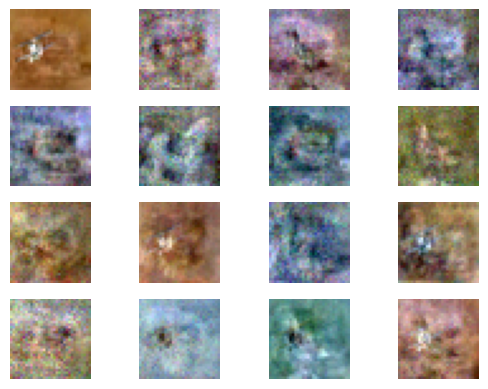

In [22]:
with torch.no_grad():
    estimated_img = (unmixing_matrix @ whitened_gradient)
    
    fig, axes = plt.subplots(4, 4)
    
    for estimate_idx, (match, ax) in enumerate(zip(lpips_match, axes.flatten())):
        estimate = estimated_img[match[0].item()]
        estimate_coeff = 1 if lpips_is_positive[match[0].item()] else -1
        img = colors.Normalize()(np.asarray(estimate_coeff * estimate).reshape(3, 32, 32).transpose(1, 2, 0))
        ax.imshow(img)
        ax.axis('off')
    plt.savefig('neg_estimate.png', dpi=500)
    plt.show()

## Original images

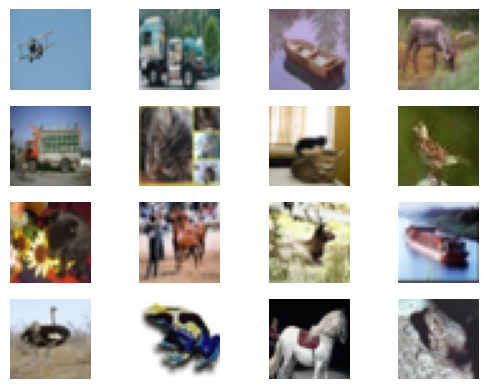

In [23]:
with torch.no_grad():
    fig, axes = plt.subplots(4, 4)
    
    for match, ax in zip(lpips_match, axes.flatten()):
        estimate = selected_val_batch_data[match[1].item()]
        img = transforms.ToPILImage()(estimate.reshape(3, 32, 32))
        img = np.asarray(img)
        ax.imshow(img)
        ax.axis('off')
    plt.savefig('reference.png', dpi=500)
    plt.show()